In [1]:
# Importing the required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,UpSampling2D,Concatenate
from tensorflow.keras.layers import Input

In [2]:
trained_path='training/'

In [3]:
img_generator = keras.preprocessing.image.ImageDataGenerator()
images_set = img_generator.flow_from_directory(
    trained_path,
    shuffle=False,
    batch_size=64,
    class_mode='binary',
    target_size=(256, 256)
)

Found 4534 images belonging to 2 classes.


In [4]:
num_images = 4534 # gotten from the output of the cell above
num_batches = num_images // 64 + 1

# initialize an empty list to store the images
X = []
Y = []
# loop over the batches and extract the images
for i in range(num_batches):
    batch = next(images_set)
    batch_images = batch[0] # this contains the images
    batch_labels = batch[1] # this contains 0s and 1s
    for ind, lb in enumerate(batch_labels):
        '''
        a label of 0 means the image belongs to ground truth image,
        and a label of 1 means that the image belongs to the ground truth mask
        '''
        if lb == 0: 
            X.append(batch_images[ind])
        else:
            Y.append(np.mean(batch_images[ind], axis=2)) # Y shape is (m, 256, 256)

In [5]:
# shuffle the dataset
from sklearn.utils import shuffle

X, Y = shuffle(X, Y, random_state=100)

In [6]:
Y = np.array([(x >= 100).astype('int') for x in Y]).reshape(-1, 256, 256, 1)

In [7]:
X = np.array(X[:2000])
Y = np.array(Y[:2000])

In [8]:
# Split the datset into train and val sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=.3, random_state=100)

In [9]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_val:", Y_val.shape)

Shape of X_train: (1400, 256, 256, 3)
Shape of X_val: (600, 256, 256, 3)
Shape of Y_train: (1400, 256, 256, 1)
Shape of Y_val: (600, 256, 256, 1)


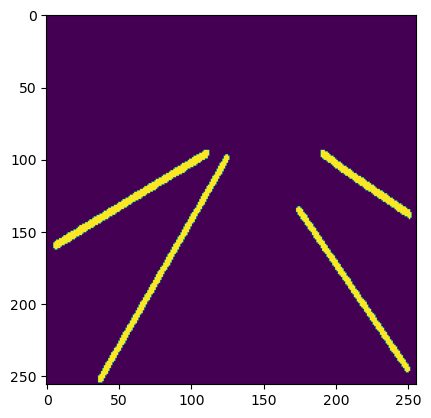

In [10]:
plt.imshow(Y_val[67])

In [11]:
X_train[1]

array([[[ 71., 111., 162.],
        [ 75., 108., 162.],
        [ 94., 131., 186.],
        ...,
        [ 76., 118., 158.],
        [ 76., 118., 158.],
        [ 75., 117., 157.]],

       [[ 73., 117., 166.],
        [ 86., 123., 176.],
        [ 78., 119., 173.],
        ...,
        [ 76., 118., 158.],
        [ 77., 119., 159.],
        [ 76., 118., 158.]],

       [[ 67., 113., 162.],
        [ 71., 117., 167.],
        [ 78., 124., 176.],
        ...,
        [ 76., 118., 158.],
        [ 78., 120., 160.],
        [ 76., 118., 158.]],

       ...,

       [[152., 161., 144.],
        [149., 158., 141.],
        [151., 160., 143.],
        ...,
        [ 25.,  29.,  38.],
        [ 24.,  28.,  37.],
        [ 24.,  28.,  37.]],

       [[148., 157., 140.],
        [151., 160., 143.],
        [155., 164., 147.],
        ...,
        [ 22.,  27.,  33.],
        [ 23.,  28.,  34.],
        [ 23.,  28.,  34.]],

       [[147., 156., 139.],
        [152., 161., 144.],
        [160., 1

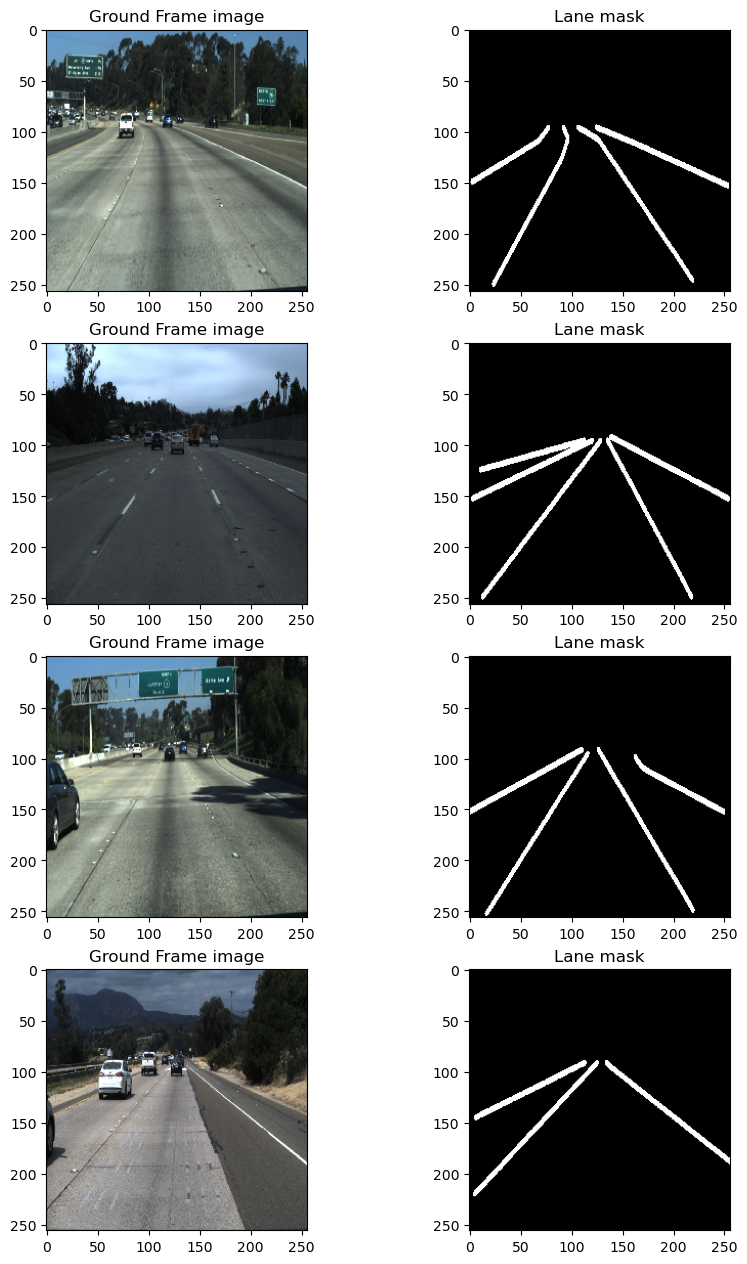

In [12]:
# visualize some samples from the training set
plt.figure(figsize=(10, 40))
s, e = 80, 84
index = 1

for i, j in zip(X_train[s:e], Y_train[s:e]):
    plt.subplot(10, 2, index)
    plt.imshow(i/255.)
    plt.title('Ground Frame image')
    
    plt.subplot(10, 2, index+1)
    plt.imshow(j, cmap='gray')
    plt.title('Lane mask')
    index += 2

In [13]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    rescale = keras.layers.Rescaling(1./255)(inputs)
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(rescale)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Decoder
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(drop5))
    merge6 = Concatenate(axis=3)([conv4, up6])
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv6))
    merge7 = Concatenate(axis=3)([conv3, up7])
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv7))
    merge8 = Concatenate(axis=3)([conv2, up8])
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv8))
    merge9 = Concatenate(axis=3)([conv1, up9])
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

model = unet()

In [14]:
# train the model
# Compile the model
model.compile(optimizer='adam', loss=keras.losses.BinaryFocalCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 256, 256, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           1,792 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 32, 32, 256)       │               0 │ conv2d_5[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 32, 32, 512)       │       1,180,160 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 32, 32, 512)       │       2,359,808 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_3               │ (None, 16, 16, 512)       │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 16, 16, 1024)      │       4,719,616 │ max_pooling2d_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 16, 16, 1024)      │       9,438,20

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epoch=6
callbacks = [
    keras.callbacks.ModelCheckpoint(f"save_at_{epoch}.keras"),
]
history=model.fit(
    X_train,
    Y_train,
    epochs=epoch,
    validation_data=(X_val, Y_val),
    callbacks=callbacks,
    batch_size=6
)

Epoch 1/6
234/234 ━━━━━━━━━━━━━━━━━━━━ 2316s 10s/step - accuracy: 0.9581 - loss: 3.8717 - val_accuracy: 0.9652 - val_loss: 0.0257
Epoch 2/6
234/234 ━━━━━━━━━━━━━━━━━━━━ 2621s 11s/step - accuracy: 0.9662 - loss: 0.0251 - val_accuracy: 0.9702 - val_loss: 0.0227
Epoch 3/6
234/234 ━━━━━━━━━━━━━━━━━━━━ 2619s 11s/step - accuracy: 0.9673 - loss: 0.0279 - val_accuracy: 0.9663 - val_loss: 0.0263
Epoch 4/6
234/234 ━━━━━━━━━━━━━━━━━━━━ 2643s 11s/step - accuracy: 0.9689 - loss: 0.0225 - val_accuracy: 0.9726 - val_loss: 0.0197
Epoch 5/6
234/234 ━━━━━━━━━━━━━━━━━━━━ 2480s 11s/step - accuracy: 0.9728 - loss: 0.0189 - val_accuracy: 0.9734 - val_loss: 0.0183
Epoch 6/6
234/234 ━━━━━━━━━━━━━━━━━━━━ 2605s 11s/step - accuracy: 0.9747 - loss: 0.0173 - val_accuracy: 0.9746 - val_loss: 0.0174


In [16]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_val, Y_val)

# Print the evaluation metrics
print('Test loss:', loss)
print('Test accuracy:', accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 242s 13s/step - accuracy: 0.9742 - loss: 0.0178
Test loss: 0.017372891306877136
Test accuracy: 0.9746036529541016


In [17]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_train, Y_train)

# Print the evaluation metrics
print('Train loss:', loss)
print('Train accuracy:', accuracy)

44/44 ━━━━━━━━━━━━━━━━━━━━ 586s 13s/step - accuracy: 0.9754 - loss: 0.0165
Train loss: 0.016233937814831734
Train accuracy: 0.975556492805481


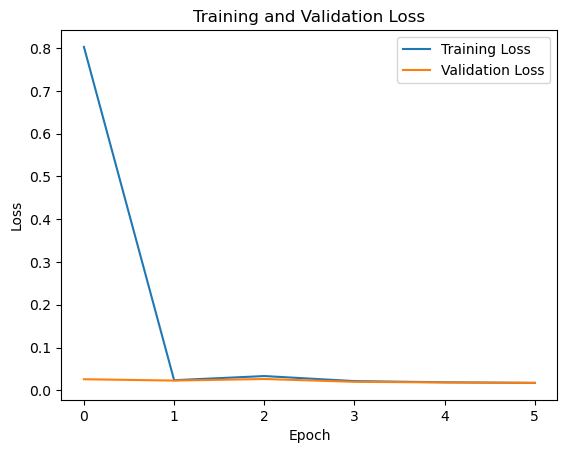

In [18]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

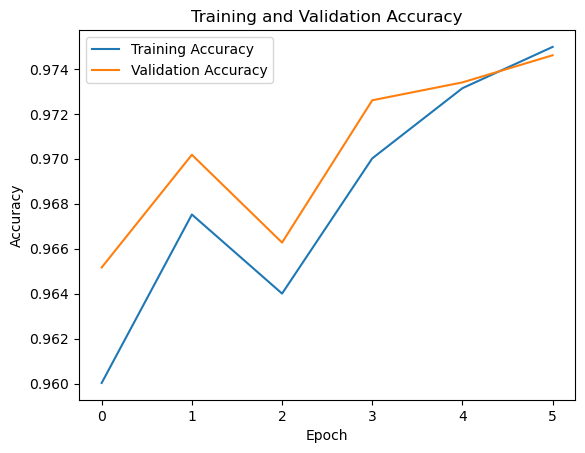

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
plt.savefig('Accuracy')